In [1]:
# Load packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 1. Preprocessing

In [2]:
# Read datasets needed
from google.colab import files 
uploaded = files.upload()

Saving ALSFRS_rev (1).csv to ALSFRS_rev (1).csv
Saving 0227_real_target.csv to 0227_real_target.csv
Saving 0227_optimal_target.csv to 0227_optimal_target.csv


In [3]:
import io
optimal_gastro = pd.read_csv(io.BytesIO(uploaded['0227_optimal_target.csv']))   # optimal_gastro means 'time to dietary consistency change'
real_gastro = pd.read_csv(io.BytesIO(uploaded['0227_real_target.csv']))    # real_gastro means whether a patient got the actual gastrostomy or not
alsfrs_R = pd.read_csv(io.BytesIO(uploaded['ALSFRS_rev (1).csv'])) 

In [4]:
optimal_gastro.drop(columns='Unnamed: 0', inplace=True)
real_gastro.drop(columns='Unnamed: 0', inplace=True)

In [ ]:
pip install lifelines

In [7]:
# Check the proportion of censored data
print("There are ", len(optimal_gastro[optimal_gastro['status_opt']==0]), "censored data in",len(optimal_gastro), " optimal target")
print("There are ", len(real_gastro[real_gastro['status_real']==0]), "censored data in",len(real_gastro), " optimal target")

There are  2198 censored data in 2827  optimal target
There are  1866 censored data in 2308  optimal target


# KM estimation on each target

In [8]:
from lifelines import KaplanMeierFitter

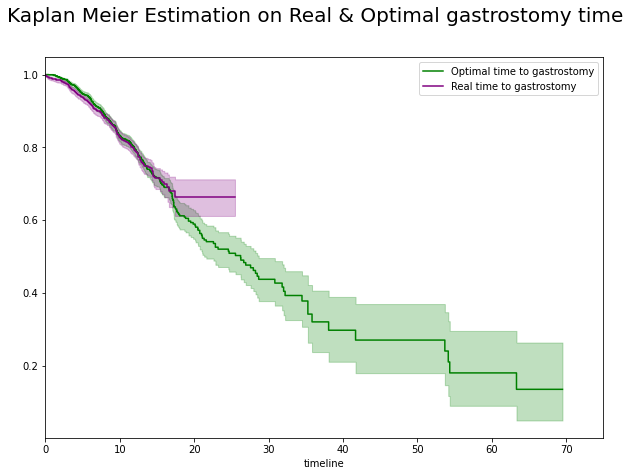

In [10]:
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 7))


OPT = kmf.fit(optimal_gastro["time_opt"], optimal_gastro["status_opt"], label='Optimal time to gastrostomy')
ax_kmf = OPT.plot(color='green')
plt.xlim([0,75])

REAL = kmf.fit(real_gastro['time_real'], real_gastro['status_real'], label='Real time to gastrostomy')
ax_kmf2 = REAL.plot(color='purple')
plt.xlim([0,75])

plt.suptitle('Kaplan Meier Estimation on Real & Optimal gastrostomy time', fontsize=20)
plt.show()

# Scatterplot of time_opt & status_opt

In [11]:
merged_target = pd.merge(optimal_gastro, real_gastro, on='SubjectID', how='inner')
merged_target

,SubjectID,time_opt,status_opt,time_real,status_real
0,348,13.18,0,13.18,0
1,533,9.44,1,9.44,1
2,3971,12.43,0,12.43,0
3,4752,12.69,0,12.69,0
4,4796,7.56,0,7.56,0
...,...,...,...,...,...
2261,997829,6.08,0,6.08,0
2262,998542,0.26,0,0.26,0
2263,998756,2.10,0,2.10,0
2264,999166,12.82,0,12.82,0


In [12]:
print("There are ", len(merged_target.query('status_opt ==1 and status_real ==1')), "occurred data in",len(merged_target), " merged target")

There are  381 occurred data in 2266  merged target


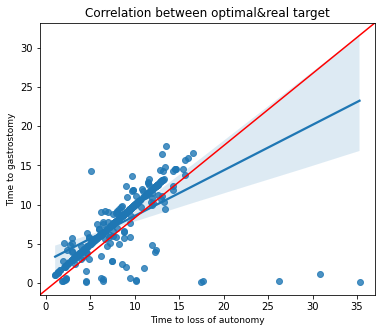

In [13]:
scat_df = merged_target.query('status_opt ==1 and status_real ==1')
fig, ax = plt.subplots(figsize=(6,5))
sns.regplot(x=scat_df['time_opt'], y=scat_df['time_real'], fit_reg=True) 
plt.xlabel('Time to loss of autonomy', fontsize=9)
plt.ylabel('Time to gastrostomy', fontsize=9)
plt.title('Correlation between optimal&real target')
ax.plot([0,30],[0,30], transform=ax.transAxes, color='red') # y=x line
plt.show() # shows enough match

In [15]:
outliers = scat_df[scat_df['time_opt']>17]
outliers

,SubjectID,time_opt,status_opt,time_real,status_real
187,75334,17.65,1,0.30,1
1081,490936,35.28,1,0.07,1
1215,543974,17.49,1,0.13,1
1912,845984,26.24,1,0.20,1
1971,876469,30.84,1,1.15,1


In [16]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [17]:
alsfrs_R[alsfrs_R['SubjectID'].isin(list(outliers['SubjectID']))][['SubjectID', 'feature_delta', 'Q3_Swallowing', 'Gastrostomy']].sort_values(by=['SubjectID','feature_delta'],ascending=True)
# Gastrostomy status are turning True -> False in several outlier patients, which can be human errors in original data

,SubjectID,feature_delta,Q3_Swallowing,Gastrostomy
20011,75334,0.30,4,True
20012,75334,1.78,4,True
20013,75334,4.54,4,True
20014,75334,6.48,4,True
20015,75334,8.22,3,True
20016,75334,10.16,3,True
20017,75334,11.77,4,True
20018,75334,13.97,3,True
20019,75334,17.65,1,False
11731,490936,0.07,3,True
